In [1]:
import findspark
SPARK_HOME = %env SPARK_HOME
findspark.init(SPARK_HOME)

In [2]:
#import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import os
from os import listdir

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType , BooleanType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName('yahoo').getOrCreate()
sc = spark.sparkContext

In [105]:
import mlflow
from mlflow import log_metric, log_param, log_artifact, pyfunc
from mlflow.pyfunc import PythonModel

"""
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./artifacts \
    --host 0.0.0.0
"""

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("yahoo")

## File imports and EDA

In [4]:
file_prefix = "yahoo_data/A2BENCHMARK/synthetic"
sdf = [spark.read.options(header='true', inferschema='true').csv(file_prefix+f"_{i+1}.csv") for i in range(100)]
sdf[0].printSchema()
sdf[0].show(5,False)

root
 |-- timestamp: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- is_anomaly: integer (nullable = true)

+----------+----------------+----------+
|timestamp |value           |is_anomaly|
+----------+----------------+----------+
|1416726000|13.8940312022431|0         |
|1416729600|33.5782735451433|0         |
|1416733200|88.9337461757894|0         |
|1416736800|125.38942370322 |0         |
|1416740400|152.961999637907|0         |
+----------+----------------+----------+
only showing top 5 rows



In [15]:
anomaly_counts = [0]*100
for i, d in enumerate(sdf):
    anomaly_counts[i] = d.where(F.col("is_anomaly")==1).count()
dict((i, anomaly_counts.count(i)) for i in anomaly_counts)

{4: 34, 9: 33, 1: 33}

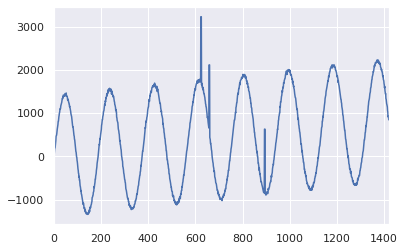

In [16]:
sdf[1].toPandas().value.plot()

## Feature Engineering

In [5]:
ts_window = Window.partitionBy().orderBy("timestamp")
testdf = sdf[1].withColumn("value_lag1", F.lag(F.col("value")).over(ts_window))
testdf = testdf.withColumn("value_diff1", F.when(F.isnull(testdf.value - testdf.value_lag1), 0)
                              .otherwise(testdf.value - testdf.value_lag1))
testdf.head(5)

[Row(timestamp=1416726000, value=27.1098884496337, is_anomaly=0, value_lag1=None, value_diff1=0.0),
 Row(timestamp=1416729600, value=40.7764421115744, is_anomaly=0, value_lag1=27.1098884496337, value_diff1=13.666553661940696),
 Row(timestamp=1416733200, value=122.541468931929, is_anomaly=0, value_lag1=40.7764421115744, value_diff1=81.7650268203546),
 Row(timestamp=1416736800, value=168.222793223618, is_anomaly=0, value_lag1=122.541468931929, value_diff1=45.681324291688995),
 Row(timestamp=1416740400, value=196.942108429181, is_anomaly=0, value_lag1=168.222793223618, value_diff1=28.719315205562992)]

In [6]:
quantiles = testdf.approxQuantile("value_diff1", [0.25,0.75],0.05)
testdf1 = testdf.join(testdf.agg(F.stddev(F.col("value_diff1")).alias("std")))\
                .withColumn("q1", F.lit(quantiles[0]))\
                .withColumn("q3", F.lit(quantiles[1]))
testdf1.show(5)

+----------+----------------+----------+----------------+------------------+------------------+-------------------+-----------------+
| timestamp|           value|is_anomaly|      value_lag1|       value_diff1|               std|                 q1|               q3|
+----------+----------------+----------+----------------+------------------+------------------+-------------------+-----------------+
|1416726000|27.1098884496337|         0|            null|               0.0|108.78974285874885|-31.779107289380136|28.33858715540009|
|1416729600|40.7764421115744|         0|27.1098884496337|13.666553661940696|108.78974285874885|-31.779107289380136|28.33858715540009|
|1416733200|122.541468931929|         0|40.7764421115744|  81.7650268203546|108.78974285874885|-31.779107289380136|28.33858715540009|
|1416736800|168.222793223618|         0|122.541468931929|45.681324291688995|108.78974285874885|-31.779107289380136|28.33858715540009|
|1416740400|196.942108429181|         0|168.222793223618|28.71

In [172]:
def predict_from_quants2(value_diff1: float, q1: float, q3: float) -> float:
    threshold = 5
    Q1 = float(q1)
    Q3 = float(q3)
    IQR = Q3 - Q1
    return 1.0 if (float(value_diff1) < (Q1 - IQR*threshold) or float(value_diff1) > Q3 + IQR*threshold) else 0.0

class UDFWrapper(PythonModel):
    def __init__(self, estimator=None):
        return None
    def predict(self, context, X):
        return np.array(list(map(predict_from_quants2(*x), X.to_numpy().T)))

### Saving/Loading model

In [173]:
with mlflow.start_run():
    mlflow.pyfunc.log_model(
            python_model = UDFWrapper(),
            registered_model_name = "yahoo_model_quant",
            artifact_path = "yahoo_models"
        )

Registered model 'yahoo_model_quant' already exists. Creating a new version of this model...
Created version '9' of model 'yahoo_model_quant'.


In [174]:
model_path = "models:/yahoo_model_quant/6"
prediction_udf = mlflow.pyfunc.spark_udf(spark, model_path)
columns = ["value_diff1", "q1", "q3"] 
predictdf = testdf1.withColumn('prediction', prediction_udf(*columns))
predictdf.show(5)

+----------+----------------+----------+----------------+------------------+------------------+-------------------+-----------------+----------+
| timestamp|           value|is_anomaly|      value_lag1|       value_diff1|               std|                 q1|               q3|prediction|
+----------+----------------+----------+----------------+------------------+------------------+-------------------+-----------------+----------+
|1416726000|27.1098884496337|         0|            null|               0.0|108.78974285874885|-31.779107289380136|28.33858715540009|       0.0|
|1416729600|40.7764421115744|         0|27.1098884496337|13.666553661940696|108.78974285874885|-31.779107289380136|28.33858715540009|       0.0|
|1416733200|122.541468931929|         0|40.7764421115744|  81.7650268203546|108.78974285874885|-31.779107289380136|28.33858715540009|       0.0|
|1416736800|168.222793223618|         0|122.541468931929|45.681324291688995|108.78974285874885|-31.779107289380136|28.338587155400

In [176]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
result = evaluator.evaluate(predictdf)
print(result)
log_artifact("yahoo.ipynb", "jup_logs")
log_param("type", "quantile")
log_param("threshold", str(5))
log_metric("AreaUnderROC", result)

"""
Currently, loading the model after saving it ends the run. In order to associate the current model with its params, I'm logging it again.
The consequences of this are that useful model versions iterate by 2, and every other experiment run is empty
"""
mlflow.pyfunc.log_model(
            python_model=quantmodel,
            registered_model_name="yahoo_model_quant",
            artifact_path="yahoo_models"
        )
mlflow.end_run()

0.665604343720491


Registered model 'yahoo_model_quant' already exists. Creating a new version of this model...
Created version '10' of model 'yahoo_model_quant'.
